In [4]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt



# Zufalls Real Datagenerator

In [5]:
import random

def generate_real():
    real_data = torch.FloatTensor(
        [
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2),
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2)
        ]
    )
    return real_data


In [6]:
generate_real()

tensor([0.8550, 0.0080, 0.9707, 0.0250])

# Diskriminator

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # Übergeordnete PyTorch-Klasse initialisieren
        super().__init__()
        
        # Schichten des neuronalen Netzes definieren
        self.model = nn.Sequential(
            nn.Linear(4,3),
            nn.Sigmoid(),
            nn.Linear(3,1),
            nn.Sigmoid()
        )
        
        # Verlustfunktion erstellen
        self.loss_function = nn.MSELoss()
        
        # Optimierer erstellen, dabei stochastischen Gradientenabstieg verwenden
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # Zähler und Akkumulator für den Fortschritt
        self.counter = 0
        self.progress = []
        
        pass

    def forward(self, inputs):
        # Einfach das Modell ausführen
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # Die Ausgabe des Netzes berechnen
        outputs = self.forward(inputs)
        
        # Verlust berechnen
        loss = self.loss_function(outputs, targets)
        
        # Zähler inkrementieren und Fehler alle 10 Aufrufe akkumulieren
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        # Gradienten nullen, einen Rückwärts-Pass durchführen, Gewicht aktualisieren
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5))
        pass

# Rauschmuster Generator

In [11]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data


# Diskriminator testen (Belohnen falls richtig)

In [12]:
D = Discriminator()

for i in range(10000):
    # Echte Daten
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # Fake-Daten
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


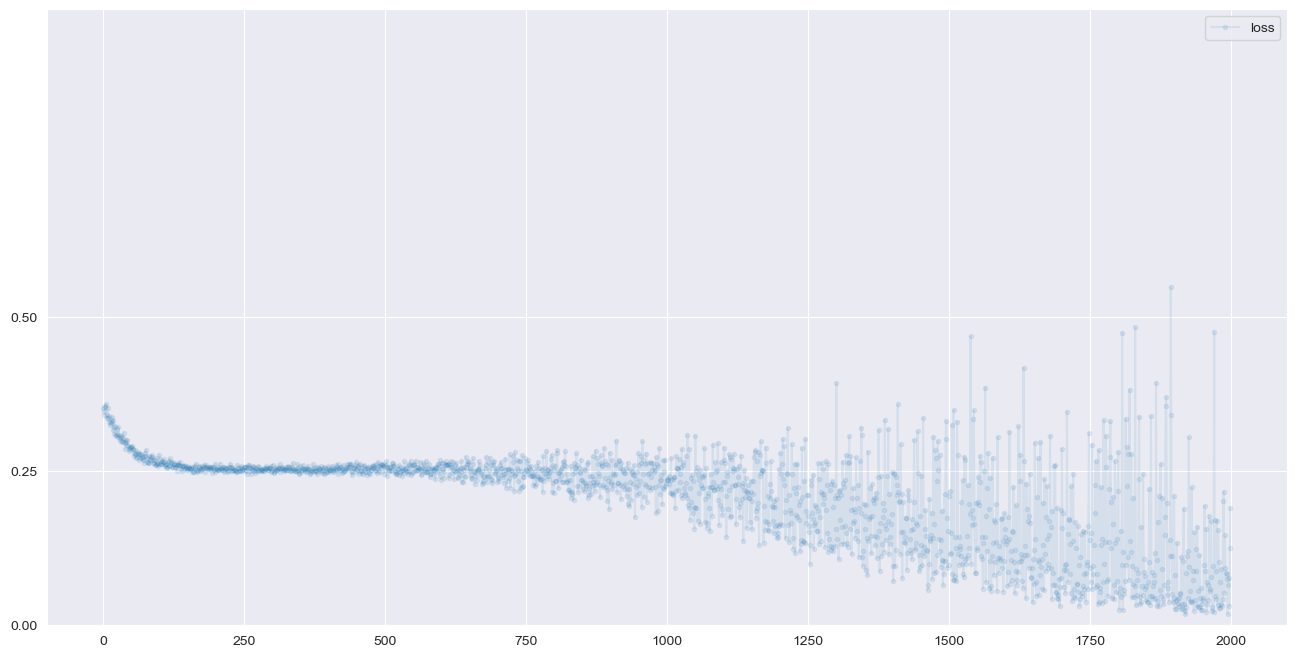

In [13]:
D.plot_progress()

In [14]:
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.767764687538147
0.17194510996341705


# Generator 

In [15]:
class Generator(nn.Module):
    
    def __init__(self):
        # Übergeordnete PyTorch-Klasse initialisieren
        super().__init__()
        
        # Schichten des neuronalen Netzes definieren
        self.model = nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid()
        )
        
        # Optimierer erstellen, einfacher stochastischer Gradientenabstieg
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # Zähler und Akkumulator für Fortschritt
        self.counter = 0
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):
        # Einfach das Modell ausführen
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)

        # pass onto Discriminator
        d_output = D.forward(g_output)

        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5))
        pass

# Testen des Generators

In [16]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5119, 0.4656, 0.4008, 0.5419], grad_fn=<SigmoidBackward0>)

# DAs GAN trainieren

In [24]:
%%time

import numpy

D = Discriminator()
G = Generator()

image_list = list()


for i in range(10000):
    
    # Bild alle 1000 Zyklen zur Liste hinzufügen
    if(i % 1000 == 0):
        image_list.append(
            G.forward(torch.FloatTensor([0.5])).detach().numpy()
        )
    
    # Diskriminator auf wahr trainieren
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # Diskriminator auf falsch trainieren
    # detach() verwenden, damit Gradienten in G nicht berechnet werden
    D.train(G.forward(torch.FloatTensor([0.5])).detach(),
            torch.FloatTensor([0.0]))
    
    # Generator trainieren
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    pass

counter =  10000
counter =  20000
CPU times: user 3.52 s, sys: 299 ms, total: 3.82 s
Wall time: 3.84 s


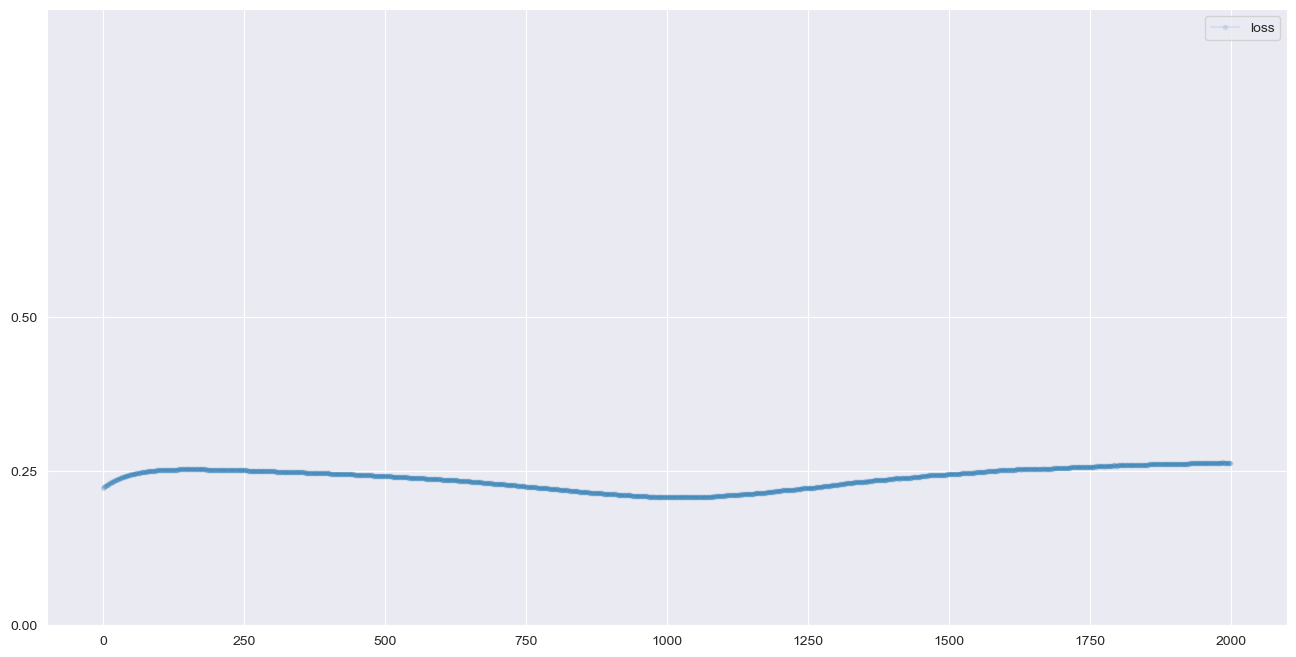

In [25]:
D.plot_progress()

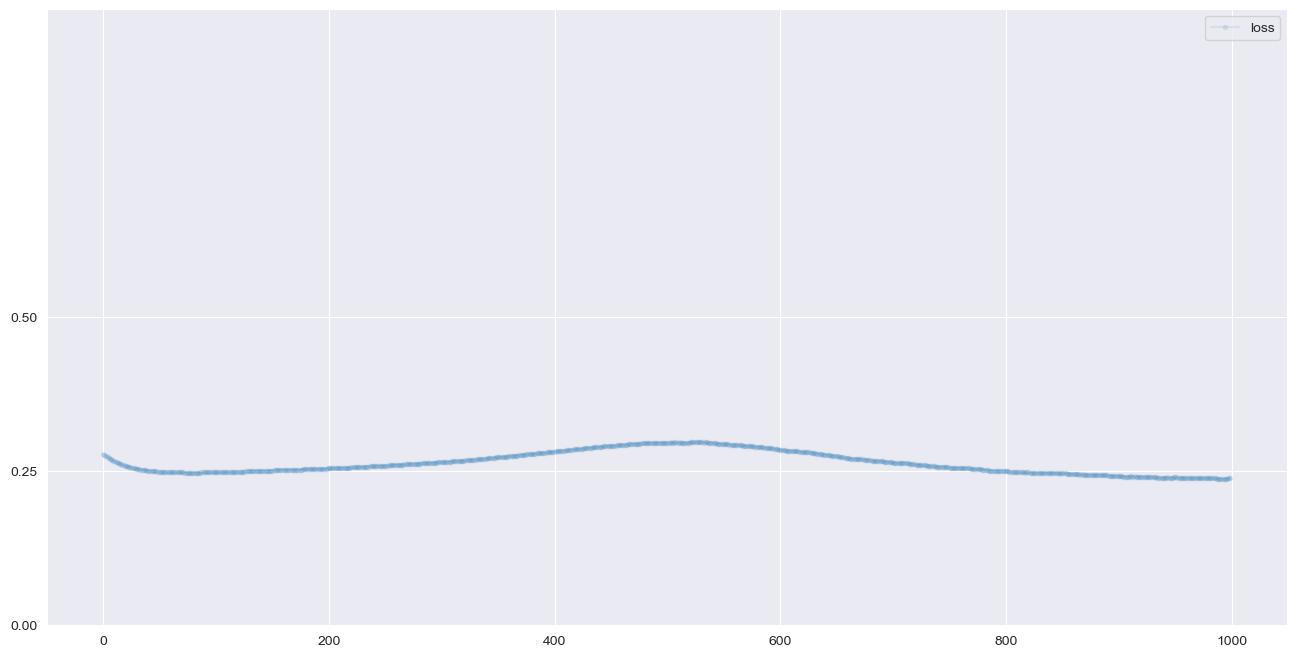

In [26]:
G.plot_progress()


# Visualisierung des Trainingszykluses Outputdaten

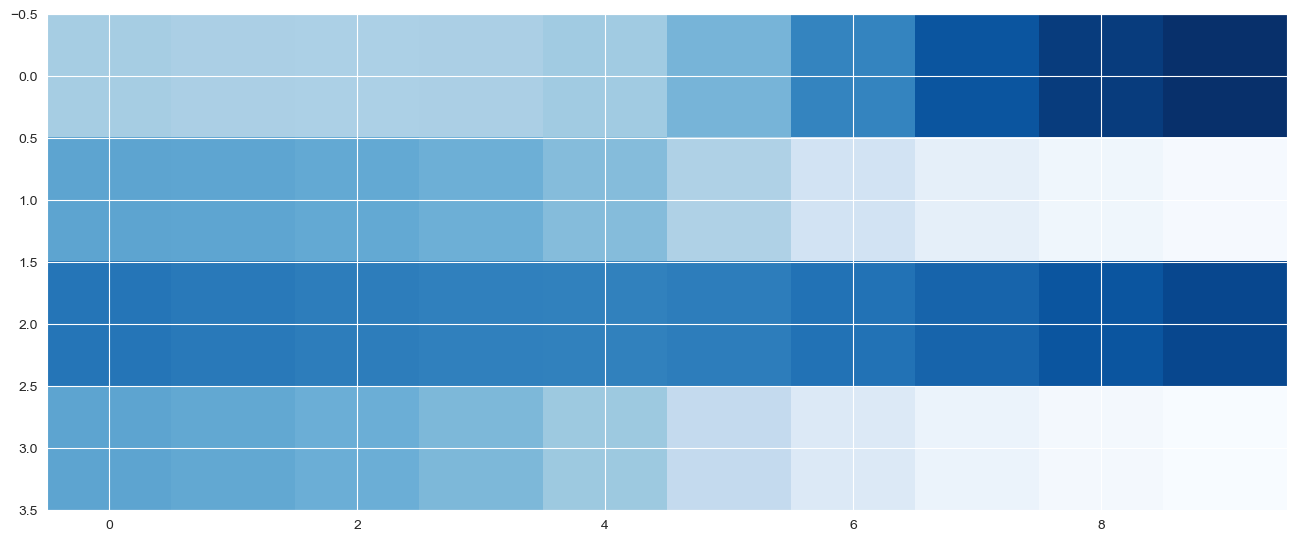

In [27]:
plt.figure(figsize=(16,8))
plt.imshow(numpy.array(image_list).T, interpolation='none',
           cmap='Blues')

# Manueller Testlauf des Generator outputs

In [31]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9303, 0.0550, 0.8637, 0.0483], grad_fn=<SigmoidBackward0>)